# Transfer Learning

**Transfer Learning:**

A research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 

Can leverage an existing neural network architecture proven to work on problems similar to our own

Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in great results with less data)

**Transfer learning use cases:**
* Computer Vision
  - [Imagenet](https://www.image-net.org/): image database organized according to the WordNet hierarchy in which each node of the hierarchy is depicted by hundreds and thousands of images.
  - Currently the best architecture is called EfficientNet
* Natural Language Processing:
  - A subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. 

## Feature Extraction

In [1]:
import  tensorflow.compat.v1 as tf
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}') 

2022-08-08 12:11:00.274630: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-08-08 12:11:00.274680: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-08-08 12:11:00.275373: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-08-08 12:11:01.771326: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Get Data (10% of 10 food classes from Food101)
import zipfile

# Download data
!wget -nc -P ../Downloads/ https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
zip_ref = zipfile.ZipFile('../Downloads/10_food_classes_10_percent.zip')
zip_ref.extractall(path='../Downloads/')
zip_ref.close()


File ‘../Downloads/10_food_classes_10_percent.zip’ already there; not retrieving.



In [3]:
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('../Downloads/10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '../Downloads/10_food_classes_10_percent'.
There are 10 directories and 0 images in '../Downloads/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/pizza'.
There are 0 directories and

### Create data loaders (preparing the data using `ImageDataGenerator`)

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '../Downloads/10_food_classes_10_percent/train/'
test_dir = '../Downloads/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks

callbacks are extra functionality you can add to your models to be performed during or after training.  Some of the most popular callbacks:
* Tracking experiments with the `TensorBoard()` callback
  - Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters).  Helpful to compare the results of different models on your data.
* Model checkpoint with the `ModelCheckpoint()` callback
  - Save your model as it trains so you can stop training if needed and come back to continue where you left off.  Helpful if training takes a long time and can't be done in one sitting.
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping()` callback
  - Leave your model training for an arbitrary amount of time and have it stop training automaticaly when it ceases to improve.  Helpful when you've got a large dataset and don't know how long training will take.

Can be accessed via `tf.keras.callbacks`

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Creating models using TensorFlow Hub

TensorFlow Hub is a repo of trained ml models

we can access pretrained models on: https://tfhub.dev/

**ResNet**
- Deep Residual Learning for Image Recognition.


In [6]:
# Compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'



In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer, 
            should be equal to number of target classes, default 10.as_integer_ratio
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Create the model
    model = tf.keras.Sequential()
    # Create Sequential layer from existing url
    feature_extractor_layer = hub.KerasLayer(model_url, 
            trainable=False,
            name="feature_extraction_layer",
            input_shape=IMAGE_SHAPE + (3,)
        ) # freeze the already learned patterns
    # Create layers
    output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')
    
    # Add layers to the model
    model.add(feature_extractor_layer)
    model.add(output_layer)

    return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)
resnet_model.summary()

2022-08-05 11:22:08.283107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 11:22:08.283911: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070 Laptop GPU)
2022-08-05 11:22:09.089453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 11:22:09.089494: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-08-05 11:22:09.089518: I tensorflow/core/common_runtime/pluggable_device/pluggab

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="../tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50v2")]) # name of log files

Saving TensorBoard log files to: ../tensorflow_hub/resnet50v2/20220805-112211
Epoch 1/5


2022-08-05 11:22:13.470456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-05 11:22:13.565139: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node sequential/feature_extraction_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/resnet_v2_50/block1/unit_3/bottleneck_v2/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='XLA_CPU_JIT'; label='host'; T in [DT_INT32, DT_INT64]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-05 11:22:13.566509: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermu

24/24 [==============================] - ETA: 0s - loss: 1.9807 - accuracy: 0.3387

2022-08-05 11:22:20.565761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-05 11:22:20.621079: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node sequential/feature_extraction_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/resnet_v2_50/block1/unit_3/bottleneck_v2/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='XLA_CPU_JIT'; label='host'; T in [DT_INT32, DT_INT64]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-05 11:22:20.622580: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermu

24/24 [==============================] - 15s 359ms/step - loss: 1.9807 - accuracy: 0.3387 - val_loss: 1.2537 - val_accuracy: 0.6016
Epoch 2/5
24/24 [==============================] - 6s 244ms/step - loss: 0.9165 - accuracy: 0.7373 - val_loss: 0.8604 - val_accuracy: 0.7356
Epoch 3/5
24/24 [==============================] - 6s 245ms/step - loss: 0.6213 - accuracy: 0.8280 - val_loss: 0.7619 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 6s 246ms/step - loss: 0.4769 - accuracy: 0.8667 - val_loss: 0.7038 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 6s 244ms/step - loss: 0.3831 - accuracy: 0.9027 - val_loss: 0.6744 - val_accuracy: 0.7824


In [12]:
# Create a function to plot our loss curves...
# Note: you could put this in a script and import it when needed.

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_accuracy_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


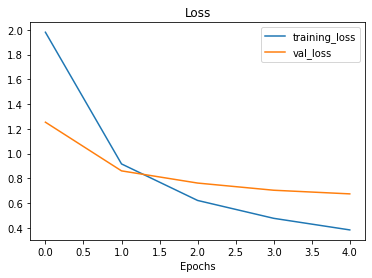

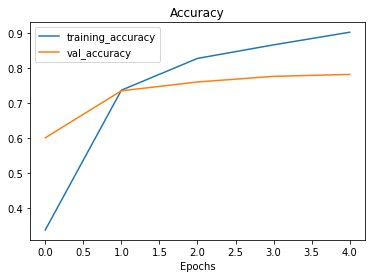

In [13]:
plot_accuracy_loss_curves(history=resnet_history)


### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [14]:
train_data_10_percent.num_classes

10

In [15]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

# Fit to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                                epochs=5,
                                                steps_per_epoch=len(train_data_10_percent),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[
                                                    create_tensorboard_callback(dir_name="../tensorflow_hub",
                                                        experiment_name="efficientnetB0")
                                                ]
                                            )


Saving TensorBoard log files to: ../tensorflow_hub/efficientnetB0/20220805-112256
Epoch 1/5


2022-08-05 11:23:02.028214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-05 11:23:02.182202: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node sequential_1/feature_extraction_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/stack_0/block_0/se_squeeze/PartitionedCall/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-05 11:23:02.183174: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node sequential_1/feature_e

23/24 [===========================>..] - ETA: 0s - loss: 1.7963 - accuracy: 0.4579

2022-08-05 11:23:05.916839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-05 11:23:06.011515: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node sequential_1/feature_extraction_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/stack_0/block_0/se_squeeze/PartitionedCall/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-05 11:23:06.012386: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node sequential_1/feature_e

24/24 [==============================] - 14s 290ms/step - loss: 1.7907 - accuracy: 0.4600 - val_loss: 1.2719 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 5s 226ms/step - loss: 1.0158 - accuracy: 0.7933 - val_loss: 0.8571 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 5s 224ms/step - loss: 0.7283 - accuracy: 0.8467 - val_loss: 0.6935 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 5s 225ms/step - loss: 0.5893 - accuracy: 0.8720 - val_loss: 0.6088 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 5s 226ms/step - loss: 0.4991 - accuracy: 0.9000 - val_loss: 0.5553 - val_accuracy: 0.8632


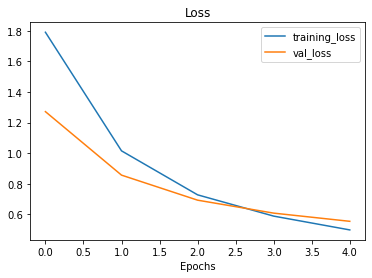

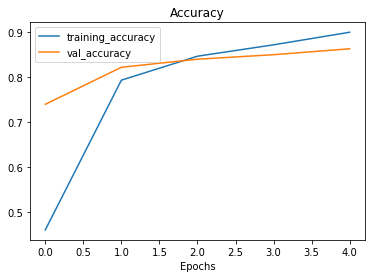

In [16]:
plot_accuracy_loss_curves(history=efficientnet_history)

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
# How many layers does our efficientnet feature extractor have?
print(efficientnet_model.layers)

# check length input weights
print(len(efficientnet_model.layers[0].weights))

# check length output weights
print(len(efficientnet_model.layers[1].weights))

[<tensorflow_hub.keras_layer.KerasLayer object at 0x7f95b2f98340>, <keras.layers.core.dense.Dense object at 0x7f953ce363b0>]
309
2


## Types of Transfer Learning

* **"As is"** transfer learning - Using an existing model with no changes (e.g. using ImageNet model on 1000 ImageNet classes)
* **"Feature extraction"** transfer learning - Use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - Use the patterns patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public.  So if you're running private experiments, do not upload them to TensorBoard.dev.

## Upload TensorBoard dev records via terminal

`
tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "efficientnetB0 vs. resnet50v2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot
`

Our TensorBoard experiments are uploaded publicly: https://tensorboard.dev/experiment/DpVXdXhbS1u6lpJv5DBBIQ/

In [22]:
# Check out what TensorBoard experiments we have.
!tensorboard dev list

2022-08-05 12:01:53.335217: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-08-05 12:01:53.335303: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-08-05 12:01:53.336121: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-08-05 12:01:53.599218: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
https://tensorboard.dev/experiment/DpVXdXhbS1u6lpJv5DBBIQ/
	Name                 efficientnetB0 vs. resnet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   DpVXdXhbS1u6lpJv5DBBIQ
	Created              2022-08-05 11:41:52 (20 minutes ago)
	Updated              2022-08-05 11:41:56 (20 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  1158

### Delete an experiment from TensorBoard

`tensorboard dev delete --experiment_id DpVXdXhbS1u6lpJv5DBBIQ`

Confirm deletion by re-checking what experiments are left.

In [25]:
!tensorboard dev delete --experiment_id DpVXdXhbS1u6lpJv5DBBIQ

2022-08-05 12:05:48.402652: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-08-05 12:05:48.402740: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-08-05 12:05:48.403549: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-08-05 12:05:48.670319: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
Deleted experiment DpVXdXhbS1u6lpJv5DBBIQ.


In [ ]:
!tensorboard dev list

2022-08-05 12:05:53.371114: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-08-05 12:05:53.371193: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-08-05 12:05:53.371866: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-08-05 12:05:53.606816: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
No experiments. Use `tensorboard dev upload` to get started.
